### boston 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : boston.csv에서 Feature 사용
- 구현 프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비

In [1]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.regression import R2Score
from torchinfo import summary

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(2)

# 저장 및 실행 위치 설정
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device => {Device}')

Device => cpu


In [3]:
# 데이터 로딩 : CSV => DataFrame
Data = '../../ML/DATA/boston.csv'

houseDF = pd.read_csv(Data)
houseDF.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


[2] 모델준비
- 학습 방법 : 지도학습 > 회귀
- 알고리즘 : 멀티 레이어 퍼셉트론

In [4]:
# 모델 설계
# 입력층의 입력값/피처 :     13개
# 출력층의 출력값/타겟 : MEDV 1개
model = nn.Sequential(nn.Linear(13,15),
                      nn.ReLU(),
                      nn.Linear(15,10),
                      nn.ReLU(),
                      nn.Linear(10,8),
                      nn.ReLU(),
                      nn.Linear(8,5),
                      nn.ReLU(),
                      nn.Linear(5,1))

In [5]:
houseDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [6]:
print(model)
summary(model, input_size=(506,13))

Sequential(
  (0): Linear(in_features=13, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=5, bias=True)
  (7): ReLU()
  (8): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [506, 1]                  --
├─Linear: 1-1                            [506, 15]                 210
├─ReLU: 1-2                              [506, 15]                 --
├─Linear: 1-3                            [506, 10]                 160
├─ReLU: 1-4                              [506, 10]                 --
├─Linear: 1-5                            [506, 8]                  88
├─ReLU: 1-6                              [506, 8]                  --
├─Linear: 1-7                            [506, 5]                  45
├─ReLU: 1-8                              [506, 5]                  --
├─Linear: 1-9                            [506, 1]                  6
Total params: 509
Trainable params: 509
Non-trainable params: 0
Total mult-adds (M): 0.26
Input size (MB): 0.03
Forward/backward pass size (MB): 0.16
Params size (MB): 0.00
Estimated Total Size (MB): 0.19

In [7]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.0636, -0.0660,  0.0761, -0.0142,  0.1185,  0.0660, -0.0319, -0.2242,
          0.0633, -0.2456,  0.0365,  0.0184, -0.0610],
        [ 0.2268,  0.0185,  0.1150,  0.1174, -0.1636, -0.1066,  0.2667, -0.2717,
         -0.0188, -0.0220,  0.1967, -0.0264,  0.0730],
        [-0.0133, -0.1553, -0.1572, -0.1347, -0.2519, -0.1800,  0.0653,  0.1825,
          0.0137, -0.1271,  0.1219, -0.1065, -0.0614],
        [-0.1520, -0.0871, -0.2570,  0.1183,  0.1078,  0.0551,  0.1362,  0.1175,
          0.0123,  0.0294,  0.0212,  0.1480,  0.1863],
        [ 0.1992,  0.1608, -0.0676, -0.0123, -0.0564,  0.1613,  0.0308,  0.2567,
          0.1407, -0.2370,  0.0811,  0.2665,  0.2464],
        [-0.0044,  0.0920, -0.2602, -0.0884,  0.1352, -0.2527,  0.2416, -0.1824,
          0.0877, -0.0105,  0.0489,  0.0269, -0.2593],
        [-0.0596, -0.1753,  0.2358, -0.0340, -0.2762,  0.0672,  0.1204, -0.1242,
         -0.0260,  0.1199, -0.1726, -0.1466, -0.0268],
        [-0.194

[3] 최적화 인스턴스 준비

In [8]:
### 모델의 가중치와 절편을 최적화해 인스턴스에 전달
adam = optim.Adam(model.parameters(), lr=0.12)

[4] 학습 ==> 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터 준비 시 진행하거나 학습 전 진행

In [9]:
# 피처와 타겟 분리
featureDF = houseDF[houseDF.columns[:-1]]
targetDF = houseDF[['MEDV']]

print(featureDF.shape, targetDF.shape)

(506, 13) (506, 1)


In [10]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size=0.2, random_state=5)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

print(f'[Feature] Train {X_train.shape}, Test {X_test.shape}, Val {X_val.shape}')
print(f'[Target]  Train {y_train.shape}, Test {y_test.shape}, Val {y_val.shape}')

[Feature] Train (323, 13), Test (102, 13), Val (81, 13)
[Target]  Train (323, 1), Test (102, 1), Val (81, 1)


[4-2] 학습 진행
- 학습 횟수 결정 ==> 에포크 설정
- 배치 크기 결정
- 배치 개수 계산

In [11]:
EPOCH = 182
BATCH_SIZE = 19
BATCH_CNT = X_train.shape[0]//BATCH_SIZE

print(f'EPOCH : {EPOCH}, BATCH_SIZE : {BATCH_SIZE}, BATCH_CNT : {BATCH_CNT}')

EPOCH : 182, BATCH_SIZE : 19, BATCH_CNT : 17


In [12]:
## 테스트/검증 함수
# ==> 가중치, 절편 업데이트 X / 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
def testing(testDF, targetDF, kind='Val'):
    # Tensor화 
    testTS = torch.FloatTensor(testDF.values).to(Device)
    targetTS = torch.FloatTensor(targetDF.values).to(Device)

    with torch.no_grad():   # 가중치, 절편 업데이트 X
        # (1) 학습 진행 - forward
        pre_y = model(testTS)
        
        # (2) 오차계산 - 손실함수
        loss = F.mse_loss(pre_y,targetTS)

        # (3) 성능평가 - R2
        r2 = R2Score()(pre_y, targetTS)

        # (4) 학습결과 출력 및 저장
        print(f'[{kind}] Loss : {loss}, R2 : {r2}')
        
    return loss, r2

In [13]:
# 모델 학습 함수
def training(X_train, y_train, valTS, valTargetTs):
    loss_history = {'Train':[], 'Val':[]}
    r2_history = {'Train':[], 'Val':[]}

    for epoch in range(EPOCH):
        # 배치손실, 배치r2스코어 변수 저장
        batch_loss, batch_r2 = 0,0

        # 배치 크기만큼 학습 진행
        for i in range(BATCH_CNT):
            start = i*BATCH_SIZE
            end = start+BATCH_SIZE

            # BS크기만큼 데이터 추출해서 Tensor화 진행
            BSX_train = torch.FloatTensor(X_train[start:end].values).to(Device)
            BSy_train = torch.FloatTensor(y_train[start:end].values).to(Device)
            print(f'X_train : {BSX_train.shape}, {BSX_train.device}, {BSX_train.dtype}')
            print(f'y_train : {BSy_train.shape}, {BSy_train.device}, {BSy_train.dtype}')

            # 학습 진행 - forward
            pre_y = model(BSX_train)

            # 오차계산 - 손실 함수
            loss= F.mse_loss(pre_y, BSy_train)
            r2 = R2Score()(pre_y, BSy_train)
            batch_loss += loss.item()
            batch_r2 += r2.item()

            # 최적화 - 가중치, 절편 업데이트 backward
            adam.zero_grad()
            loss.backward()
            adam.step()

        # 검증 - 모델이 제대로 만들어지는지 검사
        loss, r2 = testing(valTS, valTargetTs)
        loss_history['Val'].append(loss.item())
        r2_history['Val'].append(r2.item())

        # 에포크 단위손실과 성능 지표
        loss_history['Train'].append(batch_loss/BATCH_CNT)
        r2_history['Train'].append(batch_r2/BATCH_CNT)

        # 학습 결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}]\nTrain Loss : {loss_history["Train"][-1]}, R2 : {r2_history["Train"][-1]}')
        print(f'Validation Loss : {loss_history["Val"][-1]}, R2 : {r2_history["Train"][-1]}')

    return loss_history, r2_history

In [14]:
loss, r2 = training(X_train, y_train, X_val, y_val)

X_train : torch.Size([19, 13]), cpu, torch.float32
y_train : torch.Size([19, 1]), cpu, torch.float32
X_train : torch.Size([19, 13]), cpu, torch.float32
y_train : torch.Size([19, 1]), cpu, torch.float32
X_train : torch.Size([19, 13]), cpu, torch.float32
y_train : torch.Size([19, 1]), cpu, torch.float32
X_train : torch.Size([19, 13]), cpu, torch.float32
y_train : torch.Size([19, 1]), cpu, torch.float32
X_train : torch.Size([19, 13]), cpu, torch.float32
y_train : torch.Size([19, 1]), cpu, torch.float32
X_train : torch.Size([19, 13]), cpu, torch.float32
y_train : torch.Size([19, 1]), cpu, torch.float32
X_train : torch.Size([19, 13]), cpu, torch.float32
y_train : torch.Size([19, 1]), cpu, torch.float32
X_train : torch.Size([19, 13]), cpu, torch.float32
y_train : torch.Size([19, 1]), cpu, torch.float32
X_train : torch.Size([19, 13]), cpu, torch.float32
y_train : torch.Size([19, 1]), cpu, torch.float32
X_train : torch.Size([19, 13]), cpu, torch.float32
y_train : torch.Size([19, 1]), cpu, torc

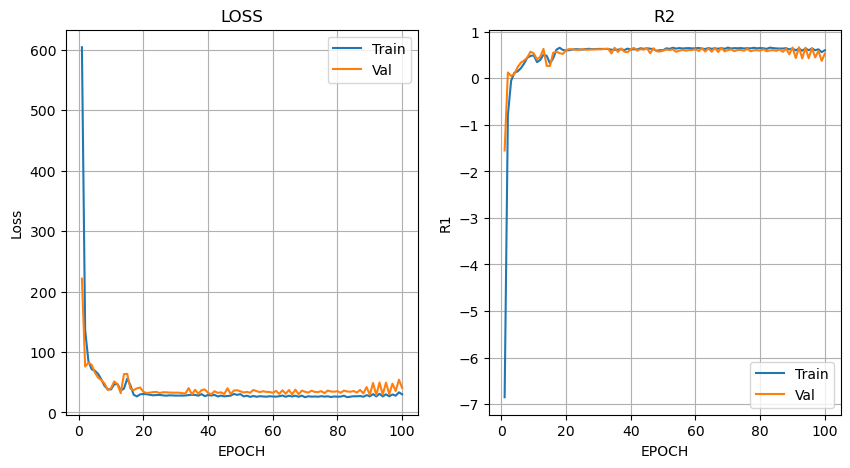

In [15]:
threshold = 100
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(range(1,threshold+1), loss['Train'][:threshold], label = 'Train')
ax[0].plot(range(1,threshold+1), loss['Val'][:threshold], label = 'Val')
ax[0].grid('--')
ax[0].legend()
ax[0].set_xlabel('EPOCH')
ax[0].set_ylabel('Loss')
ax[0].set_title('LOSS')

ax[1].plot(range(1,threshold+1), r2['Train'][:threshold], label = 'Train')
ax[1].plot(range(1,threshold+1), r2['Val'][:threshold], label = 'Val')
ax[1].grid('--')
ax[1].legend()
ax[1].set_xlabel('EPOCH')
ax[1].set_ylabel('R1')
ax[1].set_title('R2')

plt.show()